In [1]:
%pip install -q pyarrow open_clip_torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
%env AWS_REQUEST_PAYER=requester

---

In [3]:
from tqdm.auto import tqdm
import numpy as np
import torch
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

from rastervision.pipeline.file_system import download_if_needed, list_paths
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


---

## Load embeddings

In [5]:
emb_uris = list_paths('s3://raster-vision-ahassan/qe/embeddings/naip/ma/2021/', ext='.parquet')
len(emb_uris)

INFO:botocore.tokens:Loading cached SSO token for rv


15

In [6]:
emb_paths = [download_if_needed(uri) for uri in tqdm(emb_uris)]
emb_gdfs = [gpd.read_parquet(path) for path in tqdm(emb_paths)]
emb_gdf = pd.concat(emb_gdfs)
print(len(emb_gdf))

  0%|          | 0/15 [00:00<?, ?it/s]

2024-09-04 14:00:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/raster-vision-ahassan/qe/embeddings/naip/ma/2021/m_4106901_nw_19_060_20210826.parquet.
INFO:rastervision.pipeline.file_system.utils:Using cached file /opt/data/tmp/cache/s3/raster-vision-ahassan/qe/embeddings/naip/ma/2021/m_4106901_nw_19_060_20210826.parquet.
2024-09-04 14:00:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/raster-vision-ahassan/qe/embeddings/naip/ma/2021/m_4106901_sw_19_060_20210826.parquet.
INFO:rastervision.pipeline.file_system.utils:Using cached file /opt/data/tmp/cache/s3/raster-vision-ahassan/qe/embeddings/naip/ma/2021/m_4106901_sw_19_060_20210826.parquet.
2024-09-04 14:00:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/raster-vision-ahassan/qe/embeddings/naip/ma/2021/m_4106909_ne_19_060_20210826.parquet.
INFO:rastervision.pipeline.file_system.utils:Using cached file /op

  0%|          | 0/15 [00:00<?, ?it/s]

11160


In [7]:
emb_gdf['uri'] = emb_gdf['uri'].str.replace('raster-vision-ahassan/naip/2021_MA/41069', '...')
emb_gdf['embedding'] = [arr.astype(np.float16) for arr in emb_gdf['embedding']]

In [29]:
pd.set_option('display.max_colwidth', 45)
emb_gdf

,embedding,uri,geometry
0,"[-0.003696, 0.0547, -0.00926, -0.01643, 0...",s3://.../m_4106901_nw_19_060_20210826.tif,"POLYGON ((-70.00463 42.00266, -70.00463 4..."
1,"[-0.007378, 0.0508, -0.01232, -0.02223, 0...",s3://.../m_4106901_nw_19_060_20210826.tif,"POLYGON ((-70.00173 42.00268, -70.00173 4..."
2,"[-0.005203, 0.04193, -0.00824, -0.01573, ...",s3://.../m_4106901_nw_19_060_20210826.tif,"POLYGON ((-69.99883 42.00271, -69.99883 4..."
3,"[-0.003904, 0.0397, -0.010155, -0.02678, ...",s3://.../m_4106901_nw_19_060_20210826.tif,"POLYGON ((-69.99593 42.00273, -69.99593 4..."
4,"[-2.41e-05, 0.04285, -0.01131, -0.0354, 0...",s3://.../m_4106901_nw_19_060_20210826.tif,"POLYGON ((-69.99304 42.00276, -69.99304 4..."
...,...,...,...
739,"[-0.007786, 0.07574, -0.01321, -0.04053, ...",s3://.../m_4106949_nw_19_060_20210826.tif,"POLYGON ((-69.9492 41.18827, -69.9492 41...."
740,"[-0.008896, 0.0657, -0.0246, -0.01475, 0....",s3://.../m_4106949_nw_19_060_20210826.tif,"POLYGON ((-69.94634 41.18829, -69.94634 4..."
741,"[-0.01098, 0.07666, -0.02052, -0.04254, 0...",s3://.../m_4106949_nw_19_060_20210826.tif,"POLYGON ((-69.94347 41.18832, -69.94347 4..."
742,"[-0.00995, 0.07153, -0.01959, -0.05368, 0...",s3://.../m_4106949_nw_19_060_20210826.tif,"POLYGON ((-69.94061 41.18834, -69.94061 4..."


In [30]:
emb_gdf_styled = emb_gdf.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [ ]:
emb_gdf_styled

In [30]:
embeddings = torch.tensor(emb_gdf['embedding'].to_list())
embeddings.shape

torch.Size([11160, 768])

In [ ]:
%pip install tabulate

In [34]:
from tabulate import tabulate


In [62]:
emb_gdf['embedding'] = [str(e)[:35] for e in emb_gdf['embedding']]
emb_gdf['geometry'] = [str(g)[:25] for g in emb_gdf['geometry']]

In [83]:
emb_gdf['geometry'] = emb_gdf['geometry'].str[:-6] + '...'

In [71]:
emb_gdf['embedding'] = emb_gdf['embedding'].str[:-4] + '...]'

In [86]:
t = tabulate(emb_gdf.iloc[:20], showindex=False, headers=emb_gdf.columns, maxcolwidths=[35, 45, 25])

In [87]:
print(t)

embedding                            uri                                        geometry
-----------------------------------  -----------------------------------------  ----------------------
[-3.6964e-03  5.4688e-02 -9.262...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-70.00462...
[-7.3776e-03  5.0812e-02 -1.232...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-70.00172...
[-5.2032e-03  4.1931e-02 -8.239...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-69.99883...
[-3.9043e-03  3.9703e-02 -1.015...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-69.99593...
[-2.4080e-05  4.2847e-02 -1.130...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-69.99303...
[-2.0828e-03  3.9856e-02 -1.576...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-69.99013...
[-4.9591e-03  4.5959e-02 -1.377...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON ((-69.98723...
[-1.0391e-02  4.6997e-02 -1.728...]  s3://.../m_4106901_nw_19_060_20210826.tif  POLYGON

In [9]:
emb_gdf['embedding'].iloc[10].tolist()

[0.0005488395690917969,
 0.043060302734375,
 -0.01410675048828125,
 -0.03228759765625,
 0.00664520263671875,
 0.00017845630645751953,
 0.00653076171875,
 -0.01068878173828125,
 -0.0128173828125,
 -0.03369140625,
 -0.019073486328125,
 -0.03936767578125,
 -0.0216827392578125,
 -0.0303955078125,
 -0.004974365234375,
 0.00998687744140625,
 -0.019195556640625,
 -0.0081329345703125,
 -0.0026187896728515625,
 -0.01387786865234375,
 0.008819580078125,
 0.015594482421875,
 -0.00652313232421875,
 -0.004314422607421875,
 -0.0418701171875,
 0.0043487548828125,
 0.00662994384765625,
 -0.01186370849609375,
 0.02642822265625,
 -0.0125274658203125,
 0.00485992431640625,
 0.0126495361328125,
 0.034271240234375,
 -0.028167724609375,
 0.025115966796875,
 0.0125732421875,
 -0.0249481201171875,
 0.0146484375,
 -0.01355743408203125,
 -0.01021575927734375,
 0.007694244384765625,
 0.01485443115234375,
 -0.00010842084884643555,
 -0.040191650390625,
 0.0117645263671875,
 0.00839996337890625,
 -0.003852844238281

---

## Init `RasterSource`s

In [28]:
uris = set(emb_gdf['uri'])
_uri_to_rs = {}

---

## Load model

In [17]:
import open_clip

model_name = 'ViT-L-14'
model, _, _ = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [18]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
model.load_state_dict(ckpt)
model = model.eval()

## Search

In [19]:
def uri_to_rs(uri: str):
    if uri not in _uri_to_rs:
        _uri_to_rs[uri] = RasterioSource(
            uri, channel_order=[0, 1, 2], allow_streaming=True)
    return _uri_to_rs[uri]

In [20]:
def emb_idx_to_chip(i: int, chip_gdf: gpd.GeoDataFrame, out_shape: tuple[int, int] = (400, 400)):
    i = int(i)
    chip_info = chip_gdf.iloc[i]
    uri = chip_info.uri
    chip_window_geom = chip_info.geometry
    chip_window = Box.from_shapely(chip_window_geom)
    rs = uri_to_rs(uri)
    chip = rs.get_chip_by_map_window(chip_window, out_shape=out_shape)
    return chip

In [21]:
def show_top_chips(chip_scores: torch.Tensor,
                   chip_gdf: gpd.GeoDataFrame,
                   top_inds: list[int] = None,
                   nrows: int = 5,
                   ncols: int = 5,
                   figsize: tuple[float, float] = (12, 12),
                   w_pad: int = -2.5,
                   h_pad: int = -2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices.numpy()
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, chip_gdf)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()
    return fig

In [22]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_chip_scores_pca(text_queries, embs, pca, num_pcs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    text_emb_pca = pca.transform(text_emb)[:, num_pcs]
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_text_emb(text_queries):
    with torch.inference_mode():
        text = tokenizer(text_queries)
        text_emb = model.encode_text(text)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu()
    return text_emb


def _get_chip_scores(text_emb, image_embs):
    with torch.inference_mode():
        chip_scores = torch.cosine_similarity(text_emb, image_embs)
    return chip_scores

  0%|          | 0/8 [00:00<?, ?it/s]

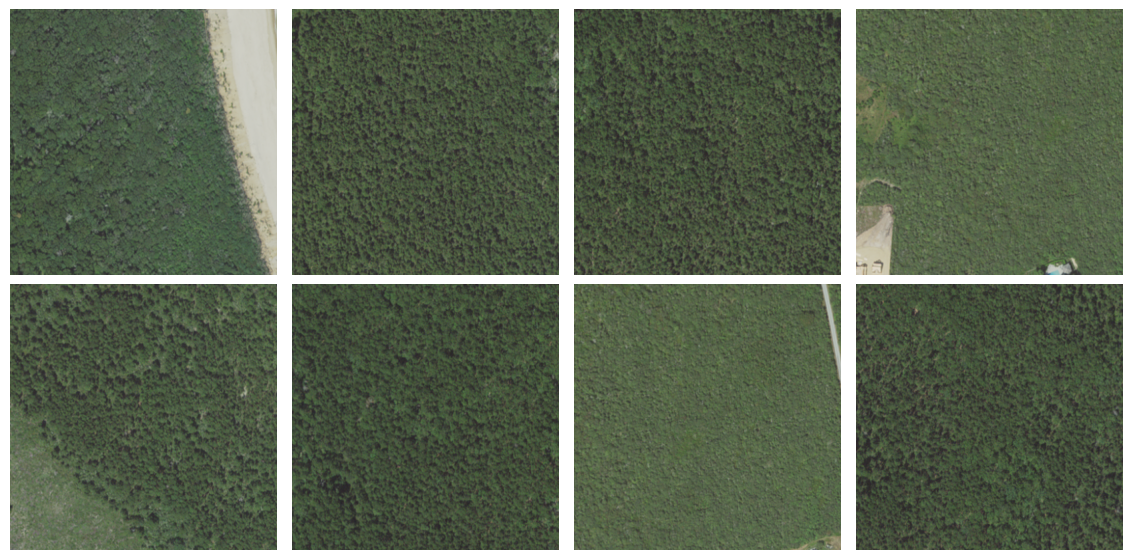

In [31]:
chip_scores = get_chip_scores(['trees'], embeddings)
_ = show_top_chips(
    chip_scores,
    emb_gdf,
    nrows=2,
    ncols=4,
    figsize=(12, 6),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))

  0%|          | 0/8 [00:00<?, ?it/s]

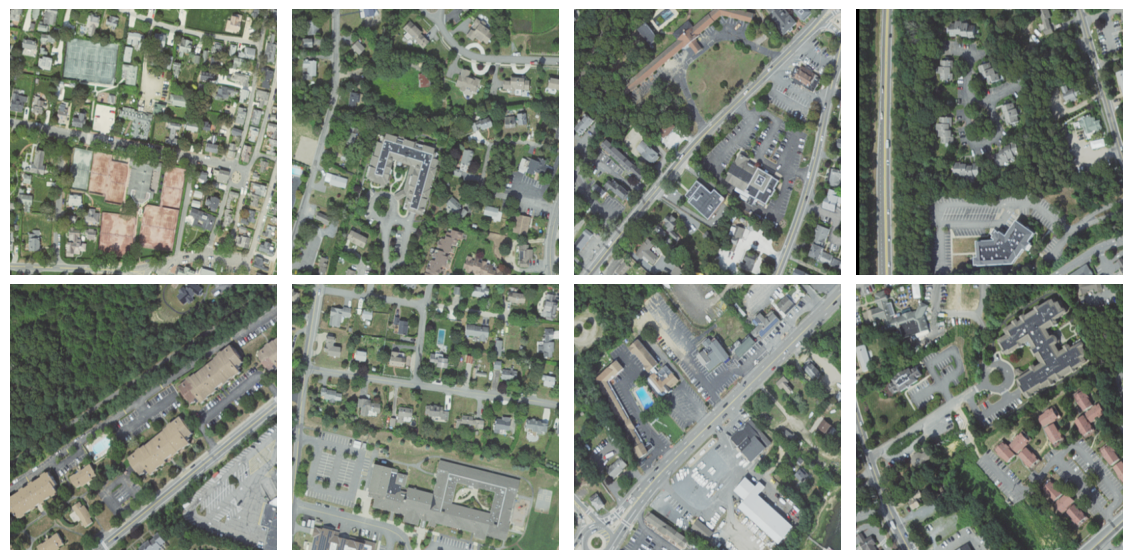

In [32]:
chip_scores = get_chip_scores(['buildings'], embeddings)
_ = show_top_chips(
    chip_scores,
    emb_gdf,
    nrows=2,
    ncols=4,
    figsize=(12, 6),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))

---